In [3]:
import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
import time

# Datasets utilisés pour tester les algorithmes

En premier dataset, on prend un mélange gaussien en dimension 3 pour pouvoir tester rapidement les algorithmes.\
On normalise les données, ce qui est nécessaire pour ne pas faire exploser les exponentielles qui seront utilisées par la suite. 

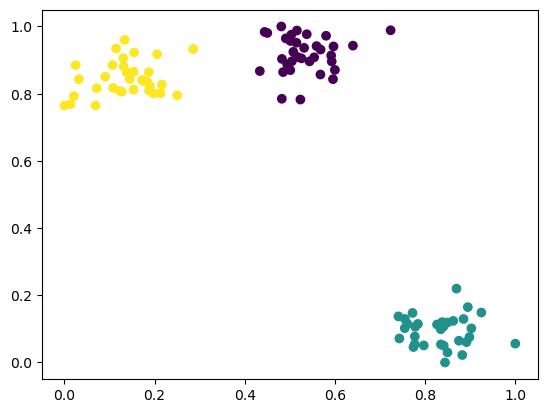

In [4]:
from sklearn.datasets import make_blobs

Xb, yb = make_blobs(n_features=3, random_state=42)
Xb = (Xb - Xb.min(axis=0))/(Xb.max(axis=0) - Xb.min(axis=0))
plt.scatter(Xb[:,0], Xb[:,1], c=yb)

Le deuxième dataset utilisé est digits de sklearn. Il contient des images de nombres écrits à la main sur une image de 8x8 pixels

In [5]:
from sklearn.datasets import load_digits

digits = load_digits()
Xd = digits.data
yd = digits.target

Text(0.5, 1.0, 'chiffre 1')

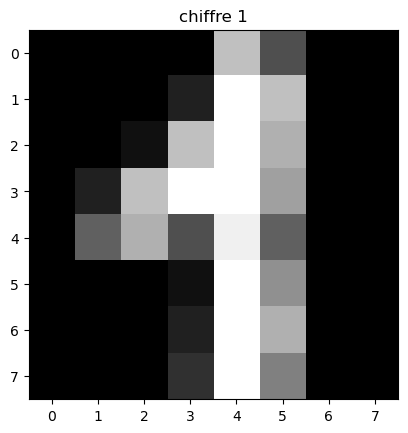

In [6]:
i = 42
plt.imshow(Xd[i].reshape(8, 8), cmap='gray')
plt.title(f"chiffre {yd[i]}")

# Détermination des $\sigma_i$

Dans SNE et T-SNE, il est nécessaire de déterminer les $\sigma_i$ qui correspondent aux écarts types des gaussiennes centrées sur les points des différents datasets
On utilise le mélange gaussien

In [7]:
# Fonction pour déterminer les pj|i à i fixé
def compute_p_i(X, i, sigma_i):
    sqeuclidean = lambda x: np.inner(x, x)
    n = len(X)
    p_i = np.zeros(n)
    for j in range(n):
        if i == j:
            continue
        
        # on ajoute un petit epsilon de 5e-5 pour éviter que l'exponentielle donne un chiffre inférieur au 0 machine.
        p_i[j] = np.exp(-sqeuclidean(X[i] - X[j])/(2*sigma_i**2 + 5e-5))
    return p_i / p_i.sum()

# permet d'obtenir la perplexité à partir des données et d'un certain sigma pour un i fixé
def compute_perp_i(X, i, sigma_i):
    p_i = compute_p_i(X, i, sigma_i)
    return (p_i**(-p_i)).prod()

On peut ensuite tracer l'évolution de la perplexité en fonction du $\sigma$ choisi.

(1.0000066087320876, 98.99941220590198)

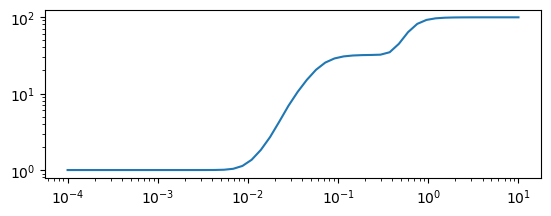

In [8]:
i = 5
sigma_list = np.logspace(-4, 1)
l = np.zeros(len(sigma_list))
for k in range(len(sigma_list)):
    sigma = sigma_list[k]
    l[k] = compute_perp_i(Xb, i, sigma)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(sigma_list, l)

ax.set_xscale('log')
ax.set_yscale('log')
l[0], l[-1]

On remarque que la fonction est croissante et que les valeurs suggérées pour la perpléxité (entre 5 et 100) sont justifiées.\
On va par la suite utiliser un algorithme de dicothomie pour trouver le $\sigma$ qui correspond à la perpléxité souhaitée.

# Implémentation de l'algorithme SNE

## class History

Cette classe est implémentée pour définir l'objet qui sera retournée lors du fit du SNE. Il permet de faciliter l'affichage de graphiques et de produire un .gif pour voir l'évolution de Y en fonction des itérations.

In [50]:
from matplotlib.animation import FuncAnimation

class History:
    loss: npt.NDArray[np.float64]
    Y: npt.NDArray[np.float64]
    
    def __init__(self, loss: npt.NDArray[np.float64], Y: npt.NDArray[np.float64]):
        self.Y = Y
        self.loss = loss
    
    # Permet de concaténer deux instances de la classe History
    def concatenate(self, h2: 'History') -> 'History':
        loss = np.concatenate((self.loss, h2.loss))
        Y = np.concatenate((self.Y, h2.Y))
        return History(loss, Y)
        
    # Permet d'afficher la loss
    def plot_loss(self, label="loss"):
        plt.plot(self.loss, label=label)
    
    # Permet d'afficher la configuration de Y à l'itération i. Par défaut c'est la dernière configue qui est affichée.
    def plot_Y_i(self,y , i=-1):
        plt.scatter(self.Y[i, :, 0], self.Y[i, :, 1], c=y)
        
    # Permet de créer un .gif à partir du Y
    def anim_Y(self, y: npt.NDArray[np.float64], name: str, interval=100, folder=".", prop=1):
        fig, ax = plt.subplots()
        
        Y = self.Y[::prop]
        
        def animation(i, Y, y, prop):
            ax.clear()
            ax.set_title(f'{name} : Frame {i*prop}')
            ax.scatter(Y[i, :, 0], Y[i, :, 1], c=y)


        update = lambda frame: animation(frame, Y, y, prop)

        anim = FuncAnimation(fig, update, len(Y), repeat=False, interval=interval)

        anim.save(f"{folder}/{name}.gif")

# Implémentation des momentums

In [204]:
class Momentum:
    alpha: int
    def __init__(self, alpha=0):
        self.alpha = alpha
    
    def derivative_term(self, dC: npt.NDArray[np.float64], Y: npt.NDArray[np.float64], k: int, lr: float):
        if self.alpha == 0 or k < 2: return lr * dC
        return lr * dC - self.alpha * (Y[k-1]-Y[k-2])
    
class NesterovMomentum(Momentum):
    dC_last: npt.NDArray[np.float64] = None
    
    def __init__(self, alpha=0):
        super().__init__(alpha)
        
    def derivative_term(self, dC, Y, k, lr):
        if self.dC_last is None: self.dC_last = np.zeros(Y[0].shape)
        result = lr * (dC + self.alpha * (dC - self.dC_last))
        self.dC = dC
        return result
    
class AdaGard(Momentum):
    G: npt.NDArray[np.float64] = None
    
    def __init__(self, alpha=0):
        super().__init__(alpha)
    
    def derivative_term(self, dC, Y, k, lr):
        if self.G is None: self.G = np.zeros(Y[0].shape)
        
        self.G += dC**2
        return  lr * dC / np.sqrt(self.G + 1e-14)
    
class RMSProp(Momentum):
    E: npt.NDArray[np.float64] = None
    gamma: int
    
    def __init__(self, alpha=0, gamma=.9):
        super().__init__(alpha)
        self.gamma = gamma
        
    def derivative_term(self, dC, Y, k, lr):
        if self.E is None: self.E = np.zeros(Y[0].shape)
        
        self.E = self.gamma * self.E + (1-self.gamma)*dC**2
        return lr * dC/np.sqrt(self.E + 1e-14)
    
class Adam(Momentum):
    beta1: int
    beta2: int
    m: npt.NDArray[np.float64] = None
    v: npt.NDArray[np.float64] = None
    
    def __init__(self, alpha=0, beta1=.9, beta2=.999):
        super().__init__(alpha)
        self.beta1 = beta1
        self.beta2 = beta2
        
    def derivative_term(self, dC, Y, k, lr):
        if self.m is None: self.m = np.zeros(Y[0].shape)
        if self.v is None: self.v = np.zeros(Y[0].shape)
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * dC
        self.v = self.beta2 * self.v + (1 - self.beta2) * dC**2
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        return lr * m_hat / (np.sqrt(v_hat) + 1e-14)
        

## class SNE

In [101]:
class SNE:
    perp: int # chosen aimed perplexity
    P: npt.NDArray[np.float64] # P matrix
    Q: npt.NDArray[np.float64] # Q matrix
    n: int # number of sapmles for the dimension reduction
    
    def __init__(self, X, perp):
        self.n = len(X)
        self.P = np.zeros((self.n, self.n))
        self.Q = np.zeros((self.n, self.n))
        self.sqeuclidean = lambda x: np.inner(x, x) # ||x||²
        
        for i in range(self.n):
            self.find_sigma_i(X, i, perp)
    
    # Compute i-th row of the P matrix
    def compute_p_i(self, X: npt.NDArray[np.float64], i: int, sigma_i: float):
        for j in range(self.n):
            if i == j:
                continue
            self.P[i, j] = np.exp(-self.sqeuclidean(X[i] - X[j])/(2*sigma_i**2 + 5e-5))
        self.P[i] /= self.P[i].sum()

    # Compute the perplexity for a row of P with a sigma_i
    def compute_perp_i(self, X, i, sigma_i):
        self.compute_p_i(X, i, sigma_i)
        return (self.P[i]**(-self.P[i])).prod()

    # find the right sigma for a chosen perplexity for the i-th row (dichotomy algorithm)
    def find_sigma_i(self, X: npt.NDArray[np.float64], i: int, perp: float, err=.01, max_iter=100) -> float:
        # sigma_min and sigma_max were chosen by a graphic study. It should be generalised 
        sigma_min = 1e-3
        sigma_max = 100
        sigma = (sigma_min + sigma_max)/2
        it = 0
        perp_i = self.compute_perp_i(X, i, sigma)
        while it < max_iter and abs(perp_i - perp) > err:
            if perp_i > perp:
                sigma_max = sigma
            else:
                sigma_min = sigma
            sigma = (sigma_min + sigma_max) / 2
            perp_i = self.compute_perp_i(X, i, sigma)
            it += 1
            
        if it == max_iter: print("n'a pas convergé pour i = ", i)
        return sigma
    
    # Compute the matrix Y_table as Y_table[i, j] = Y[i] - Y[j], used for vectorisation
    def compute_Y_table(self, Y: npt.NDArray[np.float64]):
        Y_repeat = np.repeat(Y, self.n, axis=0).reshape(self.n, self.n, Y.shape[-1]) # Y_repeat[i, j] = Y[j] for all j
        return Y_repeat - np.moveaxis(Y_repeat, 0, 1) # Y_table[i, j] = Y[i] - Y[j]
    
    # Compute the Q matrix
    def compute_Q(self, Y_table: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        self.Q = np.exp(-np.linalg.norm(Y_table, axis=2))
        self.Q /= self.Q.sum(axis=1, keepdims=True)

    # Compute the gradient 
    def compute_dQ(self, Y_table: npt.NDArray[np.float64]):
        dQ = 2 * np.sum((self.P.T - self.Q.T + self.P - self.Q).reshape(self.n, self.n, 1) * Y_table, axis=1)
        return dQ
    
    # Compute the Kullback-Leibler divergence for P et Q 
    def loss(self, P: npt.NDArray[np.float64], Q: npt.NDArray[np.float64]) -> float:
        C = P * np.log((P + 1e-10) / (Q + 1e-10))
        return C.sum()
    
    def fit(self, d=2, lr=.1, max_iter=200, Y0:npt.NDArray[np.float64]=None, momentum: Momentum=None, verbose=True) -> History:
        start = time.time()
        loss_l =np.zeros(max_iter)
        
        if momentum is None: momentum = Momentum()
        
        Y = np.zeros((max_iter + 1, self.n, d))
        if Y0 is None:
            Y0 = np.random.multivariate_normal([0] * d, np.eye(d), size=self.n)
        Y[0] = Y0
        
        
        for k in range(max_iter):
            Y_table = self.compute_Y_table(Y[k])
            self.compute_Q(Y_table)
            dQ = self.compute_dQ(Y_table)
            Y[k+1] = Y[k] - momentum.derivative_term(dQ, Y, k, lr)
            loss_l[k] = self.loss(self.P, self.Q)
            
            if verbose and (k + 1) % 5 == 0: print(f"{time.time() - start:.3f}s, Itération {k + 1}/{max_iter}, loss: {loss_l[k]}")
        
        print(f"Total time : {time.time() - start:.3f}s")
        
        return History(loss_l, Y)

## Test de l'algorithme sur les datasets

### Sur les blobs

On fait un premier fit avec un learning rate à .2 et un nombre d'itérations à 15

0.004s, Itération 5/15, loss: 165.57143463128622
0.004s, Itération 10/15, loss: 116.10440392430388
0.010s, Itération 15/15, loss: 97.9461834473155
Total time : 0.010s


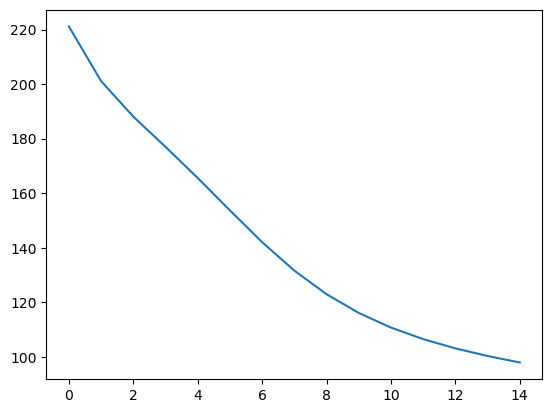

In [103]:
my_sne = SNE(Xb, perp=15)
h = my_sne.fit(2, .1, 15)
h.plot_loss()

On peut afficher Y après la dernière itération

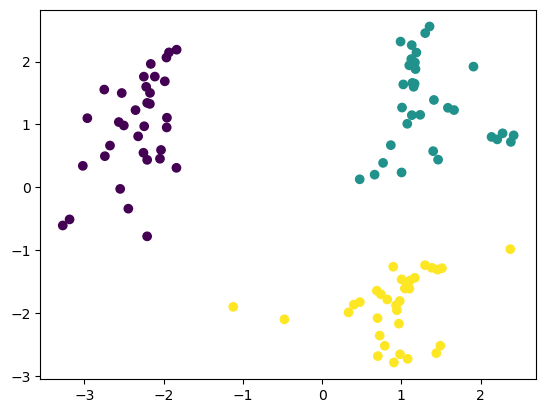

In [15]:
h.plot_Y_i(yb)

Comme 15 itérations ne sont pas assez, on peut augmenter son nombre tout en repartant du dernier Y trouvé précédemment 

0.005s, Itération 5/100, loss: 68.49138717475805
0.009s, Itération 10/100, loss: 66.95981301609064
0.010s, Itération 15/100, loss: 65.54679903326164
0.018s, Itération 20/100, loss: 64.24795196417291
0.022s, Itération 25/100, loss: 63.04860638191549
0.023s, Itération 30/100, loss: 61.935208954067235
0.029s, Itération 35/100, loss: 60.89671463127401
0.036s, Itération 40/100, loss: 59.923731279131566
0.043s, Itération 45/100, loss: 59.008650697727774
0.048s, Itération 50/100, loss: 58.14374681568293
0.052s, Itération 55/100, loss: 57.32604424356473
0.057s, Itération 60/100, loss: 56.55292555589775
0.060s, Itération 65/100, loss: 55.82070711195712
0.062s, Itération 70/100, loss: 55.12574381225194
0.062s, Itération 75/100, loss: 54.464936230932466
0.069s, Itération 80/100, loss: 53.83644018983948
0.073s, Itération 85/100, loss: 53.23865572190771
0.076s, Itération 90/100, loss: 52.66932988360017
0.076s, Itération 95/100, loss: 52.1262434733493
0.076s, Itération 100/100, loss: 51.608194887041

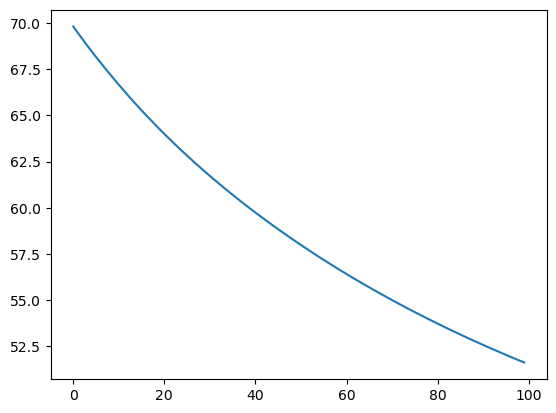

In [16]:
h2 = my_sne.fit(2, .01, 100, Y0=h.Y[-1])
h2.plot_loss()

On peut concaténer les historiques pour y voir plus clair

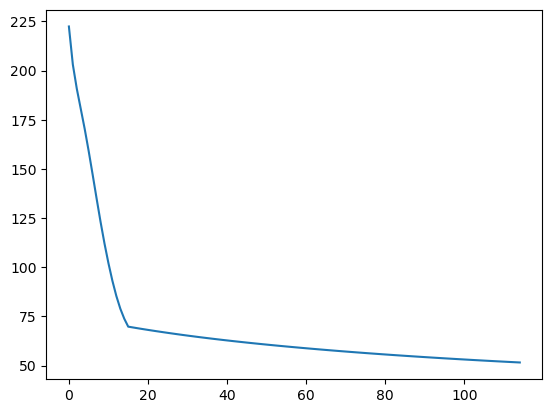

In [17]:
htot = h.concatenate(h2)
htot.plot_loss()

Pour finir, on peut enregistrer un .gif de l'évolution de Y au cours des itération 

MovieWriter ffmpeg unavailable; using Pillow instead.


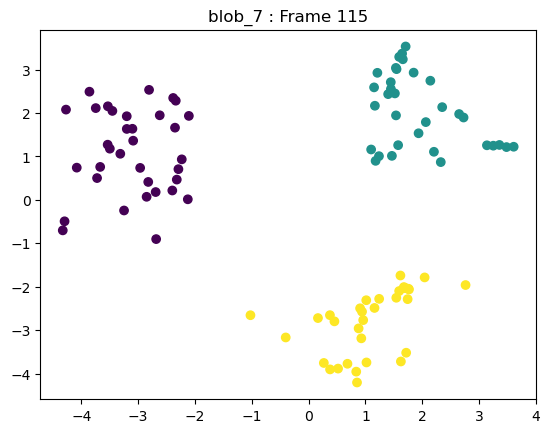

In [18]:
htot.anim_Y(yb, "blob_7", folder="./data/sne", prop=5)

### Sur les digits

In [19]:
indexes = np.random.choice(len(Xd), replace=False, size=200)
X_train, y_train = Xd[indexes], yd[indexes]

0.017s, Itération 5/1000, loss: 608.961165463724
0.033s, Itération 10/1000, loss: 587.3531700007851
0.043s, Itération 15/1000, loss: 569.3082533732685
0.059s, Itération 20/1000, loss: 553.6697793975854
0.067s, Itération 25/1000, loss: 539.5873048005926
0.085s, Itération 30/1000, loss: 526.5272820827183
0.092s, Itération 35/1000, loss: 514.093856723376
0.108s, Itération 40/1000, loss: 502.02833159747587
0.117s, Itération 45/1000, loss: 490.2309027572028
0.133s, Itération 50/1000, loss: 478.7273076614457
0.142s, Itération 55/1000, loss: 467.4948613931042
0.160s, Itération 60/1000, loss: 456.60271483027816
0.167s, Itération 65/1000, loss: 446.0537722059035
0.183s, Itération 70/1000, loss: 435.8346085130748
0.192s, Itération 75/1000, loss: 425.9030197584128
0.208s, Itération 80/1000, loss: 416.2705790583793
0.217s, Itération 85/1000, loss: 406.91170096218036
0.233s, Itération 90/1000, loss: 397.8067260093821
0.250s, Itération 95/1000, loss: 389.0031791724484
0.264s, Itération 100/1000, los

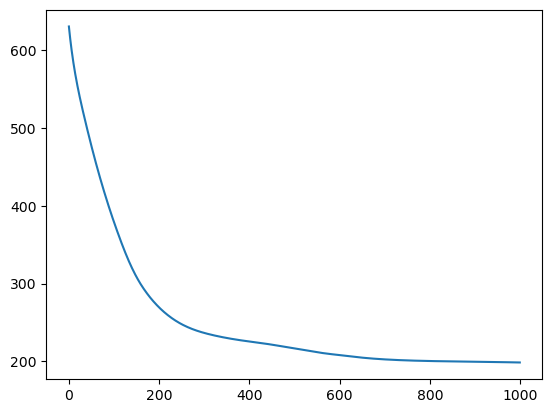

In [20]:
my_tsne = SNE(X_train, 12)
h1 = my_tsne.fit(2, .01, 1000)
h1.plot_loss()

MovieWriter ffmpeg unavailable; using Pillow instead.


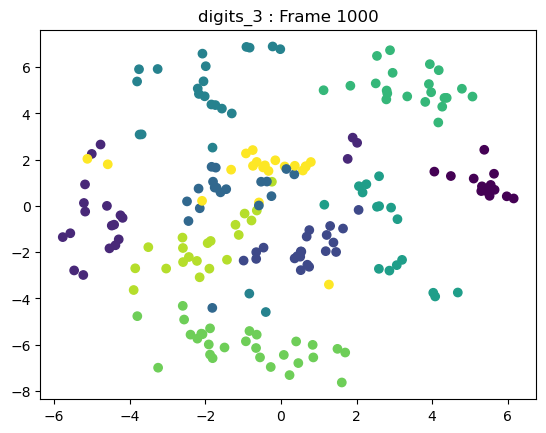

In [21]:
h1.anim_Y(y_train, "digits_3", folder="./data/sne", prop=10)

# Implémentation de T-SNE

In [22]:
class T_SNE(SNE):
    
    def __init__(self, X, perp):
        super().__init__(X, perp)
        self.P = (self.P + self.P.T) / (2 * self.n)
        
    def compute_Q(self, Y_table: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        self.Q = (1 + np.linalg.norm(Y_table, axis=2))**-1
        self.Q /= self.Q.sum()

    def compute_dQ(self, Y_table: npt.NDArray[np.float64]):
        dQ = (self.P - self.Q).reshape(self.n, self.n, 1) * Y_table * (1 + np.linalg.norm(Y_table))**-1
        return 4 * dQ.sum(axis = 1)

## Test de l'algo sur les données

### Sur les blobs

0.000s, Itération 5/100, loss: 168.81614585456038
0.009s, Itération 10/100, loss: 108.34719124759143
0.011s, Itération 15/100, loss: 70.09104246949187
0.011s, Itération 20/100, loss: 56.23753620550933
0.017s, Itération 25/100, loss: 49.849308037146976
0.017s, Itération 30/100, loss: 46.50995052391217
0.025s, Itération 35/100, loss: 43.674184078727336
0.025s, Itération 40/100, loss: 41.618872781069285
0.025s, Itération 45/100, loss: 40.737642080469264
0.033s, Itération 50/100, loss: 40.29921652678578
0.033s, Itération 55/100, loss: 40.04220258521133
0.042s, Itération 60/100, loss: 39.88034696067117
0.042s, Itération 65/100, loss: 39.77353154994227
0.042s, Itération 70/100, loss: 39.70021007791554
0.050s, Itération 75/100, loss: 39.647508197254055
0.050s, Itération 80/100, loss: 39.6062347042779
0.059s, Itération 85/100, loss: 39.56941245401384
0.059s, Itération 90/100, loss: 39.53458185304555
0.059s, Itération 95/100, loss: 39.5031066959555
0.067s, Itération 100/100, loss: 39.4761804285

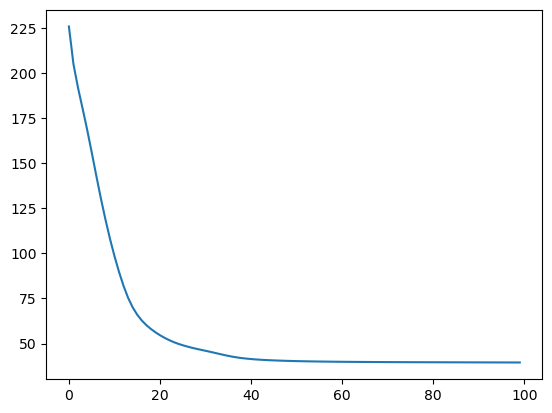

In [23]:
tsne = T_SNE(Xb, 15)
h1 = my_sne.fit(2, .1, 100)
h1.plot_loss()

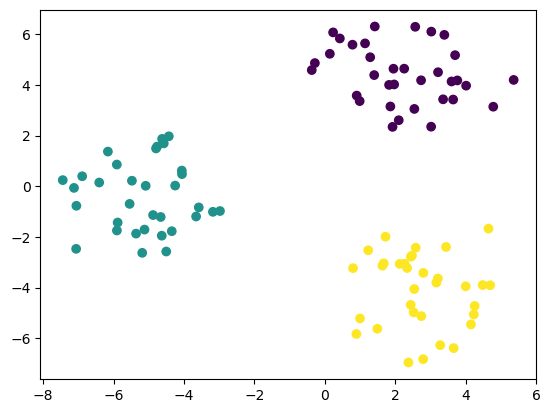

In [24]:
h1.plot_Y_i(yb)

MovieWriter ffmpeg unavailable; using Pillow instead.


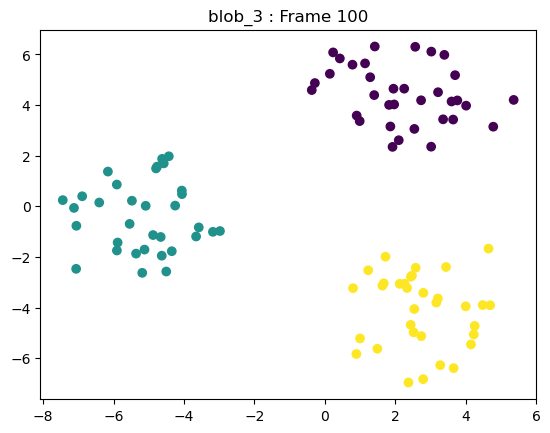

In [25]:
h1.anim_Y(yb, "blob_3", folder="./data/tsne")

### Sur les digits

In [26]:
indexes = np.random.choice(len(Xd), replace=False, size=200)
X_train, y_train = Xd[indexes], yd[indexes]

0.015s, Itération 5/15000, loss: 2.7973298321138054
0.031s, Itération 10/15000, loss: 2.7957015086350605
0.048s, Itération 15/15000, loss: 2.794066188356015
0.064s, Itération 20/15000, loss: 2.792422157560307
0.081s, Itération 25/15000, loss: 2.7907712171591097
0.098s, Itération 30/15000, loss: 2.7891152818848886
0.114s, Itération 35/15000, loss: 2.787453031251626
0.131s, Itération 40/15000, loss: 2.7857859632640234
0.150s, Itération 45/15000, loss: 2.7841135408457256
0.172s, Itération 50/15000, loss: 2.7824324331418544
0.192s, Itération 55/15000, loss: 2.7807420503667655
0.206s, Itération 60/15000, loss: 2.779045742145903
0.223s, Itération 65/15000, loss: 2.7773426009616013
0.247s, Itération 70/15000, loss: 2.77563263541719
0.264s, Itération 75/15000, loss: 2.773915074382352
0.289s, Itération 80/15000, loss: 2.7721898500607676
0.303s, Itération 85/15000, loss: 2.7704569347299435
0.321s, Itération 90/15000, loss: 2.7687155202881346
0.321s, Itération 95/15000, loss: 2.7669717749448863
0

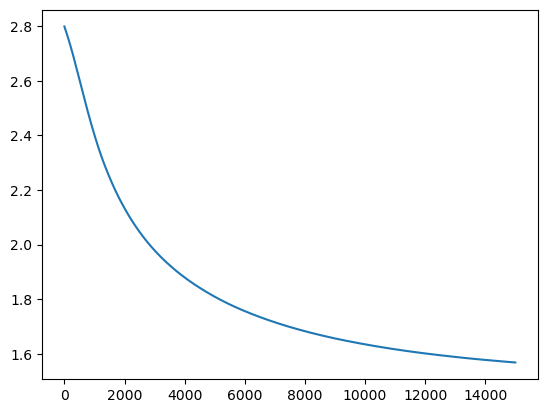

In [56]:
my_tsne = T_SNE(X_train, 12)
h = my_tsne.fit(2, 50, 15000)
h.plot_loss()

MovieWriter ffmpeg unavailable; using Pillow instead.


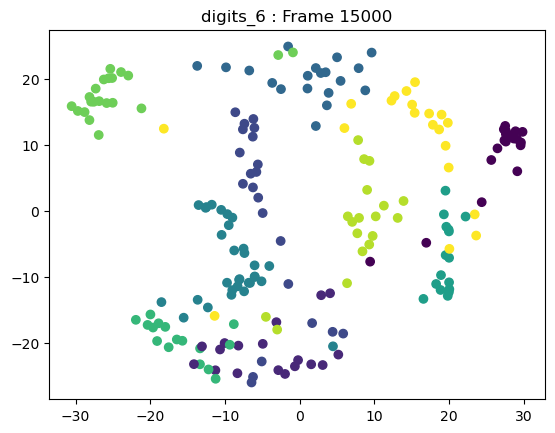

In [57]:
h.anim_Y(y_train, "digits_6", folder="./data/tsne", prop=150)

# Les différentes méthodes de momentum

In [176]:
indexes = np.random.choice(len(Xd), replace=False, size=500)
X_train, y_train = Xd[indexes], yd[indexes]
my_sne = SNE(X_train, 12)
n_iter=30

Pour comparer les différentes méthodes de momentum, on utilise l'exemple précédent sur les digits. On utilise l'algorithme SNE (moins de temps de calcul). Le but va être de trouver la méthode qui converge le mieux en 30 itérations.

In [246]:
h = my_sne.fit(2, .1, n_iter, verbose=False)

Total time : 0.939s


## Momentum

On commence avec la méthode de momentum basique. On fait varier les valeurs de alpha pour observer son influence.

Total time : 0.944s
Total time : 1.226s
Total time : 1.157s
Total time : 1.156s
Total time : 1.049s
Total time : 1.136s
Total time : 1.098s
Total time : 1.150s
Total time : 1.219s


(490.8966132795151, 2500.0)

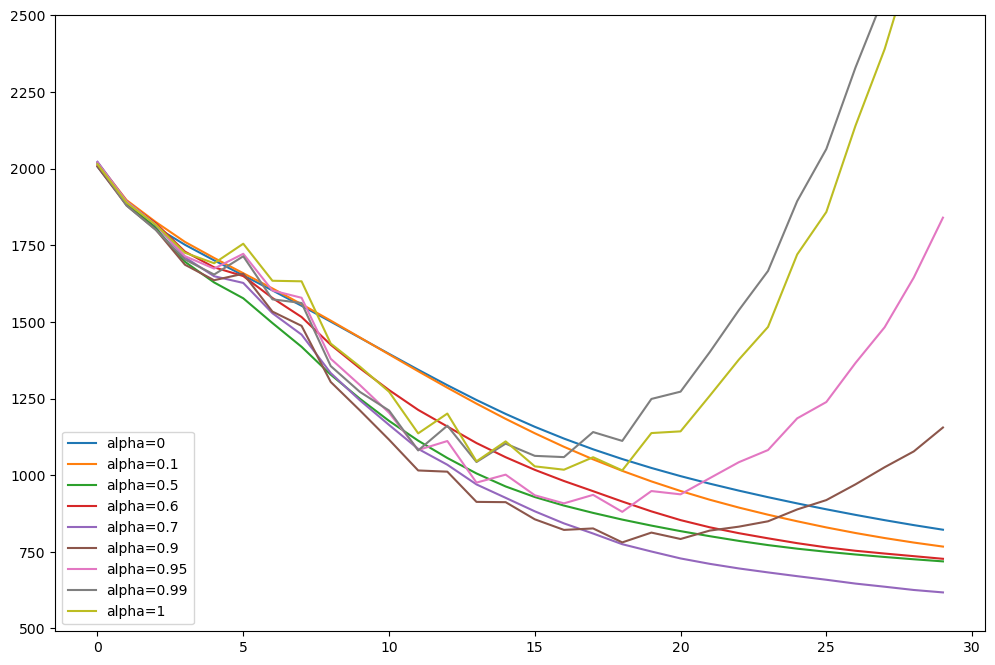

In [242]:
plt.figure(figsize=(12, 8))
for alpha in [0, .1, .5, .6, .7, .9, .95, .99, 1]:
    my_sne.fit(2, .1, n_iter, momentum=Momentum(alpha), verbose=False).plot_loss(f"alpha={alpha}")
plt.legend()
plt.ylim(top=2500)

Comme vu dans le papier, plus on se rapproche de 1 plus ça devient instable, d'où les $\alpha>0.9$ qui divergent. Cependant, on remarque aussi que plus l'on se rapproche de 1 (mais pas trop), plus la loss décroit rapidement. Il peut donc être astucieux d'implémenter $\alpha$ comme fonction décroissante au cours des itérations. Ici, le meilleur est pour $\alpha=0.7$.

In [243]:
h_momentum = my_sne.fit(2, .1, n_iter, momentum=Momentum(.7), verbose=False)

Total time : 1.004s


## Nesterov

Total time : 1.009s
Total time : 0.971s
Total time : 0.909s
Total time : 0.905s
Total time : 0.905s
Total time : 0.939s
Total time : 1.061s
Total time : 1.132s
Total time : 1.128s


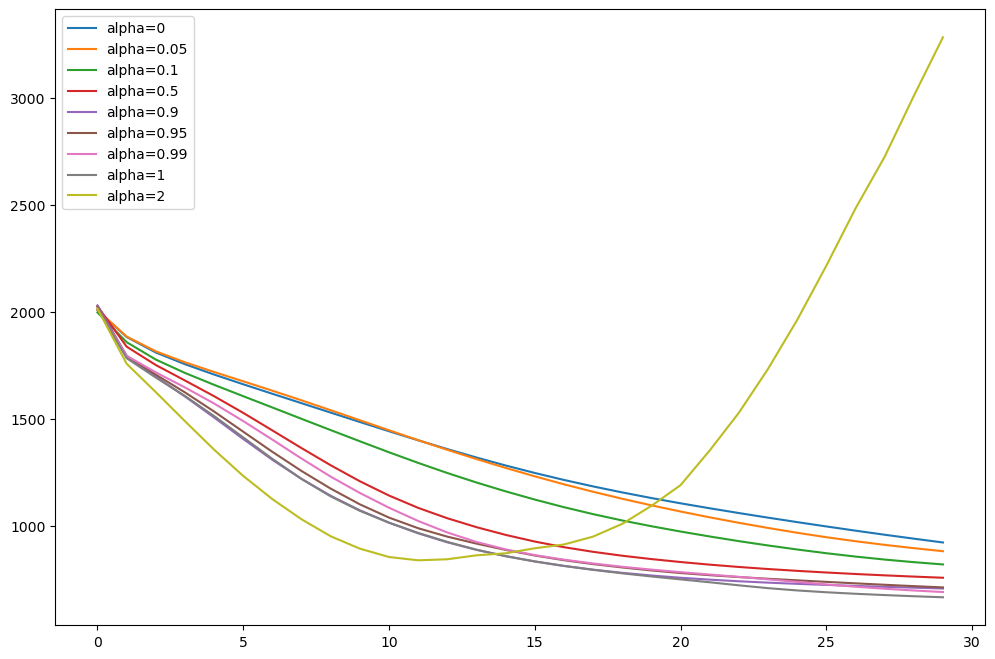

In [180]:
plt.figure(figsize=(12, 8))
for alpha in [0, 0.05, .1, .5, .9, .95, .99, 1, 2]:
    my_sne.fit(2, .1, n_iter, momentum=NesterovMomentum(alpha), verbose=False).plot_loss(f"alpha={alpha}")
plt.legend()

Ici on remarque que $\alpha$ n'est pas contraint à $]0,1[$ puisque pour $\alpha=1$ ça converge bien. Cependant il y a peu d'itérations et sûrement que la loss diverge plus tard pour un $\alpha$ grand. Le meilleur est ici $\alpha=1$.

In [187]:
h_nesterov = my_sne.fit(2, .1, n_iter, momentum=NesterovMomentum(1), verbose=False)

Total time : 1.021s


## AdaGrad

Total time : 1.002s
Total time : 1.108s
Total time : 1.101s
Total time : 1.129s
Total time : 1.097s
Total time : 1.108s
Total time : 1.129s
Total time : 1.117s
Total time : 1.076s
Total time : 1.021s


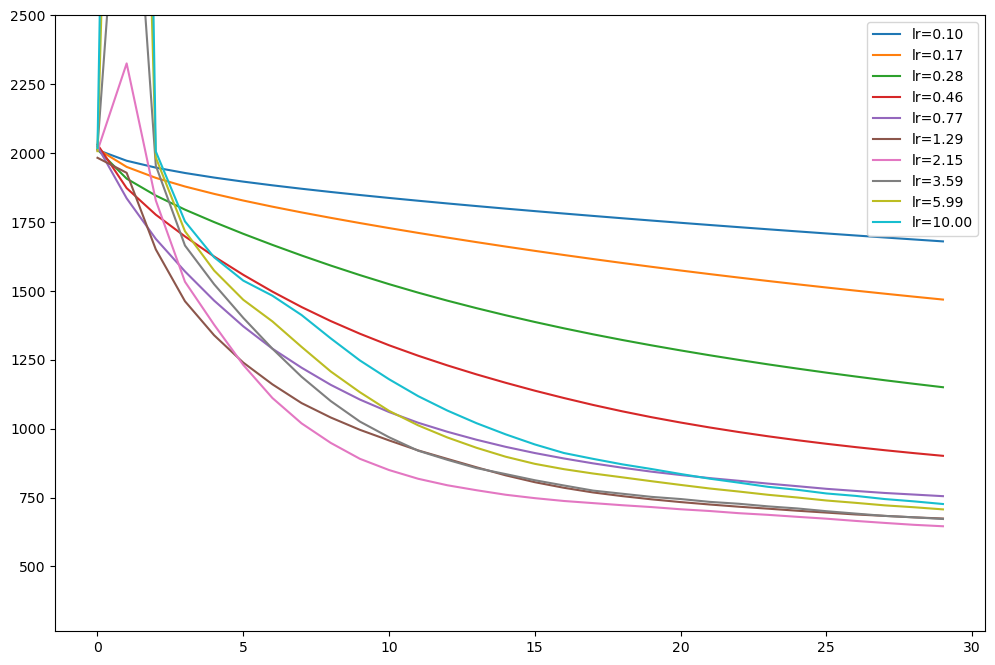

In [ ]:
plt.figure(figsize=(12, 8))
for lr in np.logspace(-1,1,10):
    my_sne.fit(2, lr, n_iter, momentum=AdaGard(), verbose=False).plot_loss(f"lr={lr:.2f}")
plt.ylim(top=2500)
plt.legend()

Ici, si on augmente trop le lr, un pic apparaît dans les premières itérations. Un lr trop faible va augmenter le temps de convergence tandis qu'un lr trop fort va augmenter don instabilité dans les premières itérations. On remarque aussi que puisque la méthode modifie le lr au cours des itérations, la loss finit toujours par se stabiliser. On garde $lr=2.15$.

In [228]:
h_adagrad = my_sne.fit(2, 2.15, n_iter, momentum=AdaGard(), verbose=False)

Total time : 0.921s


## RMSprop

Total time : 2.343s
Total time : 1.950s
Total time : 2.005s
Total time : 2.018s
Total time : 1.317s
Total time : 1.238s
Total time : 1.346s
Total time : 1.064s
Total time : 1.004s
Total time : 0.979s


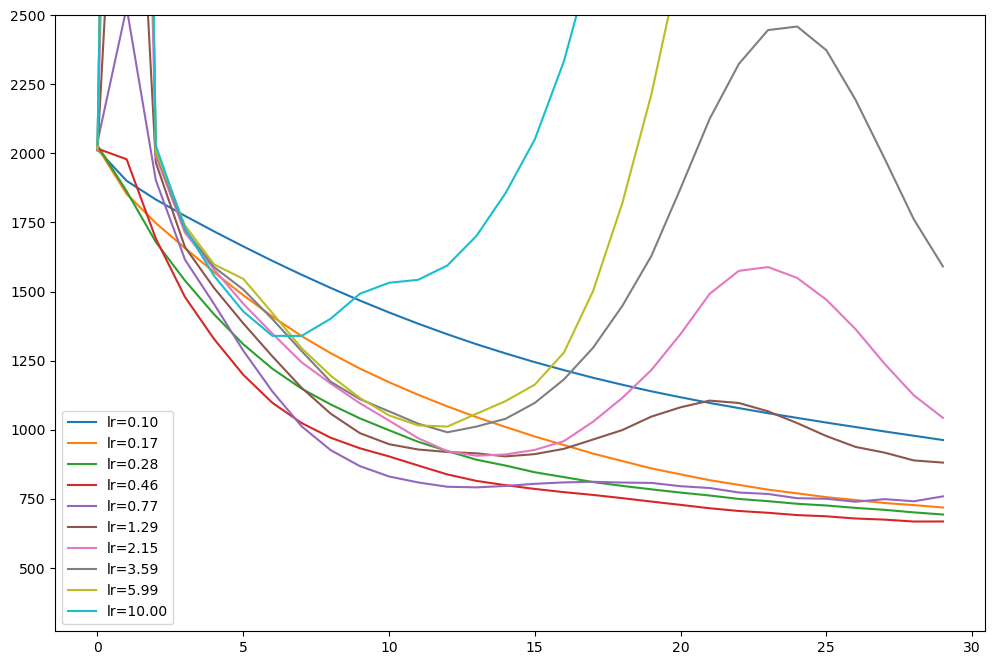

In [229]:
plt.figure(figsize=(12, 8))
for lr in np.logspace(-1,1,10):
    my_sne.fit(2, lr, n_iter, momentum=RMSProp(), verbose=False).plot_loss(f"lr={lr:.2f}")
plt.ylim(top=2500)
plt.legend()

Tout d'abord on peut voir que cette méthode donne des loss beaucoup plus instables que la méthode précédente. On prend $lr=0.46$.

In [230]:
h_rmsprop = my_sne.fit(2, 0.46, n_iter, momentum=RMSProp(), verbose=False)

Total time : 1.002s


## Adam

Total time : 1.022s
Total time : 1.163s
Total time : 1.102s
Total time : 1.149s
Total time : 1.171s
Total time : 1.176s
Total time : 1.211s
Total time : 1.224s
Total time : 1.260s
Total time : 1.289s


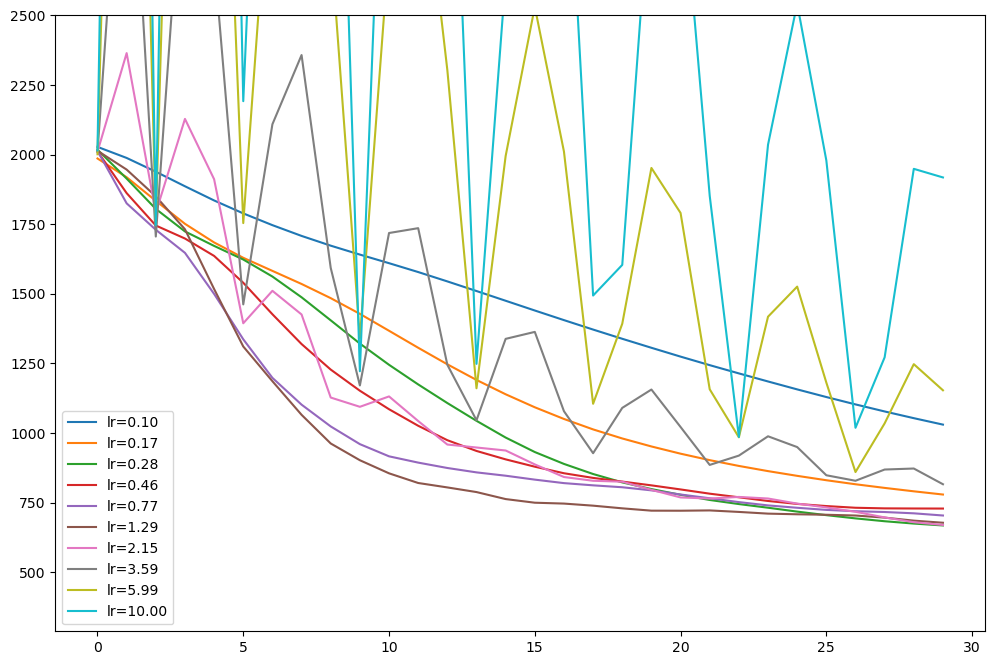

In [231]:
plt.figure(figsize=(12, 8))
for lr in np.logspace(-1,1,10):
    my_sne.fit(2, lr, n_iter, momentum=Adam(), verbose=False).plot_loss(f"lr={lr:.2f}")
plt.ylim(top=2500)
plt.legend()

On remarque de très grosses oscillations (mais qui doivent très certainement converger pour un grand nombre d'itérations). Ici on part sur $lr=0.28$.

In [232]:
h_adam = my_sne.fit(2, 0.28, n_iter, momentum=Adam(), verbose=False)

Total time : 1.138s


## Comparaison 

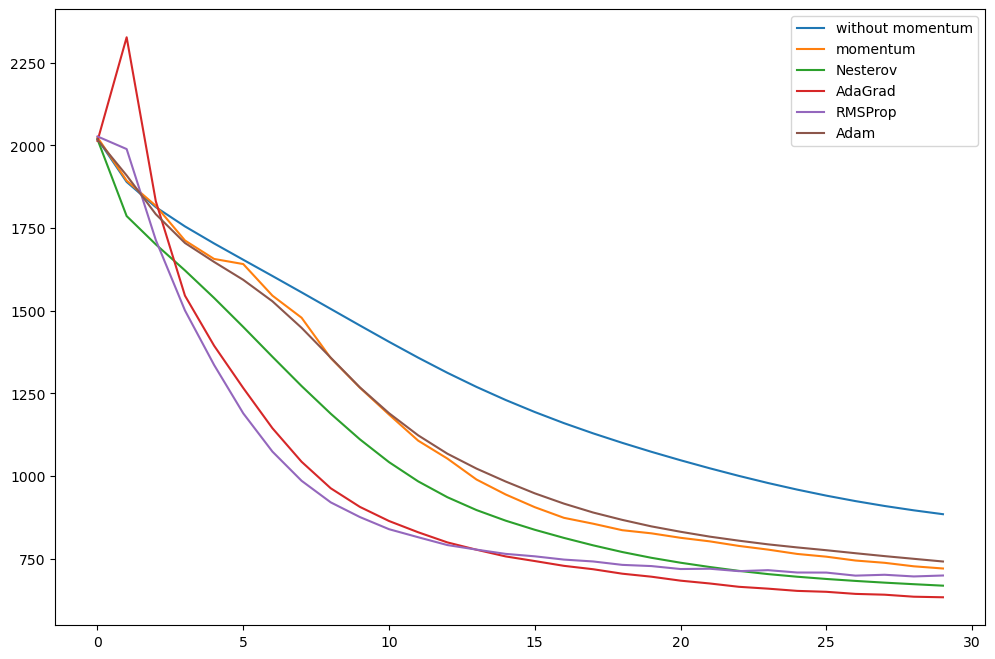

In [247]:
plt.figure(figsize=(12, 8))
h.plot_loss(label = "without momentum")
h_momentum.plot_loss(label = "momentum")
h_nesterov.plot_loss(label="Nesterov")
h_adagrad.plot_loss(label="AdaGrad")
h_rmsprop.plot_loss(label="RMSProp")
h_adam.plot_loss(label="Adam")
plt.legend()

Sur ce graphique, on peut commenter plusieurs choses. Tout d'abord, il semble pertinent d'utiliser une méthode de momentum. C'est en effet la méthode sans momentum qui a les pires performances. On remarque aussi que pour notre exemple, AdaGrad est le grand gagnant malgré son pic important du début. Aussi, Adam ne fait pas un bon score alors que c'est le plus utilisé en ML. Il faut cependant noter que cet exemple ne reflète en rien la réalité, surtout au vu du nombre très faible d'itérations.

MovieWriter ffmpeg unavailable; using Pillow instead.


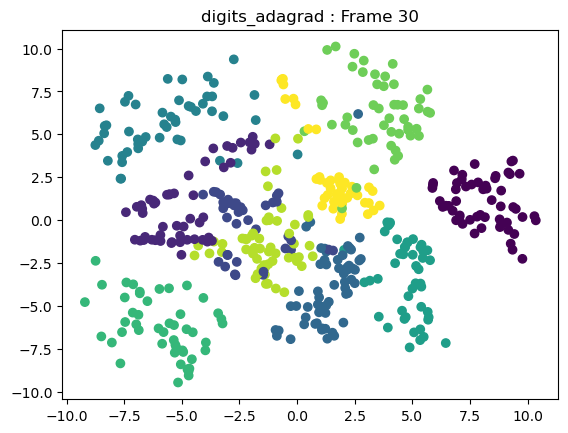

In [248]:
h_adagrad.anim_Y(y_train, "digits_adagrad", folder="./data/sne")